In [40]:
#Math librairies
import numpy as np
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from scipy.signal import argrelextrema
import math

#Astro libraries
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric

from astropy import coordinates as coord

from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
cosmo = cosmology.setCosmology('planck18') 
print (cosmo.h)

#Plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import matplotlib.colors as colors

import matplotlib.animation as animation

0.6766


## Simulation Parameters

In [41]:
#Time parameters
t         = 0      # current time of the simulation

tEnd      = 12  # time at which simulation ends (Gyr)
dt        = .01    # timestep

T=np.linspace(t, tEnd, int(tEnd / dt) +1) #list contaning all time values
T=np.array(T)

#Hernquist softening length (Mpc)
softening = 15

G = 43007 # Gravitational constant in appropriate units

# Local group size in kpc
local_group = 562

## Cinematics functions

In [42]:
def getAcc(pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

In [43]:
def DynamicalFriction(pos, mass, vel, G):
    N = len(mass)
    friction = np.zeros((N,3), dtype='float')
    
    # Precompute scale radii and host profiles
    r_s_values = np.zeros(N)
    rho_values = np.zeros(N)
    sigma_values = np.zeros(N)
    epsilon_values = np.zeros(N)
    for i in range(N):
        if mass[i] > 0:
            
            r_s_values[i] = profile_nfw.NFWProfile.nativeParameters(M=mass[i] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='vir')[1]
            if r_s_values[i] > 8.0:   # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                epsilon_values[i] = 2.2 * r_s_values[i] - 14
            else:
                epsilon_values[i] = 0.45 * r_s_values[i]
    
            r_s = r_s_values[i]
            for j in range(N):
                if i != j and mass[j] > 0:
                    dr = pos[i] - pos[j]
                    r = np.linalg.norm(dr)
                
                    
                    if r < 200:  # this can be changed to r_200 later, but should be close
                        if rho_values[j] == 0:
                            profile_host = profile_nfw.NFWProfile(M=mass[j] * 1.e10 * cosmo.h, c=10.0, z=0.0, mdef='vir') # this assumes mass in solar masses
                            rho_values[j] = profile_host.density(r * cosmo.h) / 1.e10 * cosmo.h**2
                            v_max = profile_host.Vmax()[0]
                            sigma_values[j] = v_max * 1.4393 * (r / r_s)**0.354 / (1 + 1.1756 * (r / r_s)**0.725)
                        
                        rho = rho_values[j]
                        sigma = sigma_values[j]
                    
                        
                        dv = vel[i] - vel[j]
                        v = np.linalg.norm(dv)
                        x = v / np.sqrt(2 * sigma**2)
                        gamma = r / epsilon_values[i]
                        
                        fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho / max(v, 50)**3 * (math.erf(x) - 2 * x * math.exp(-x**2) / np.sqrt(np.pi))
                        friction[i] -= dv * fricmag
    return friction


## Orbit integration function

In [44]:
def OrbitIntegration(positions, velocities, masses) : 
    
    # Convert to Center-of-Mass frame
    velocities -= np.mean(masses * velocities,0) / np.mean(masses)

    # calculate initial gravitational accelerations

    acc = getAcc( positions, masses, G, softening )
    fric = DynamicalFriction(positions, masses, velocities, G)


    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    print ("Nt:", Nt)

    # save particle orbits for plotting trails
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = positions

    exists_save = np.ones((N,Nt+1))

    vel_save = np.zeros((N,3,Nt+1))
    vel_save[:,:,0] = velocities     

    mass_save=np.zeros((N,Nt+1))
    mass_save[:,0]=np.linalg.norm(masses,axis=1)


    t_all = np.arange(Nt+1)*dt

    acc_save = np.zeros((N,Nt+1))
    fric_save = np.zeros((N,Nt+1))


    acc_save[:,0] = np.linalg.norm(acc, axis=1)
    fric_save[:,0] = np.linalg.norm(fric, axis=1)

    t=0

    # Simulation Main Loop = Leapfrog integration for N galaxies 
    #   00   *ribbit*
    #  (--)
    # ( || )
    # ^^~~^^

    for i in range(Nt):
        
        # (1/2) kick
        velocities += (acc + fric) * dt /2.0

        # drift
        positions += velocities * dt

        # update accelerations
        acc = getAcc( positions, masses, G, softening )

        # update dynamical friction
        fric = DynamicalFriction(positions, masses, velocities, G)
        
        # (1/2) kick
        velocities += (acc + fric) * dt/2.0

        # update time
        t += dt

        # save positions for plotting trail
        pos_save[:,:,i+1] = positions
        mass_save[:,i+1]=np.linalg.norm(masses, axis=1)
        acc_save[:,i+1] = np.linalg.norm(acc, axis=1)
        fric_save[:,i+1] = np.linalg.norm(fric, axis=1)


        # merging condition

        for l in range(N):
            for m in range(N):

                if l != m :
                    if np.linalg.norm(positions[l,:]-positions[m,:], axis=0) < 10 :

                        if masses[l] > masses[m] :
                            remove = m
                            keep = l
                        else:
                            remove = l
                            keep = m

                        if exists_save[remove,i] > 0:

                            print('Galaxy '+str(remove)+' has merged with galaxy '+ str(keep) +' at',t,'Gyr')

                            if remove==1 and keep==0:
                                t_merge=t 
                                b=10
                           
                            positions[keep] = (masses[keep] * positions[keep] + masses[remove] * positions[remove] ) / (masses[keep] + masses[remove] )
                            velocities[keep] = (masses[keep] * velocities[keep] + masses[remove] * velocities[remove] ) / (masses[keep] + masses[remove] )

                            masses[keep]=masses[keep]+masses[remove]
                            masses[remove]=[0]
                            exists_save[remove,i:-1] = 0


    # Calculating impact parameter :

    r_M31 = np.linalg.norm(pos_save[1,:,:]-pos_save[0,:,:],axis=0)




    # Find the merger index. Also set the distances to -1 after the merger of one of the pairs:

    b_M31_MW_array = np.ones(N) * 800.       # first minimum of the distance
    rmin_M31_MW_array = np.ones(N) * 800.    # minimum of the distance
    t_b_M31_MW_array = np.ones(N) * 11.      # time of first minimum of the distance
    t_m_M31_MW_array = np.ones(N) * 11.      # time of merger [default = 11]




    merged = np.where((exists_save[1,:] == 0) | (exists_save[0,:] == 0) )[0] # either the MW or the M31 no longer exist 
    r_M31[merged] = np.ones(len(merged)) * -1

    minima = argrelextrema(r_M31[:], np.less)[0]
    rmin_M31_MW_array = np.min(r_M31[r_M31[:] > 0] )
        
    if len(merged) > 0: # a merger has happened.
        t_m_M31_MW_array = t_all[merged[0]]
            
    if len(minima) > 0: # there is at least one local minimum
        b_M31_MW_array= r_M31[minima[0]]
        t_b_M31_MW_array = t_all[minima[0]]
    else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
        if len(merged) > 0:
            b_M31_MW_array= 10. 
            t_b_M31_MW_array = t_all[merged[0]]

    b=b_M31_MW_array


    time=t_b_M31_MW_array 


    print ("b MW - M31:", b_M31_MW_array)
    print( 't =', t_b_M31_MW_array)

 
    times_MW = np.where(exists_save[0,:-1] > 0)[0]
    times_M31 = np.where(exists_save[1,:-1] > 0)[0]


    # Velocities check

    v=np.dot((vel_save[0,:,0] - vel_save[1,:,0]), (vel_save[0,:,0] - vel_save[1,:,0]))**.5
    print('Total velocity=', v, 'km/s')

    vr=np.dot((vel_save[0,:,0]-vel_save[1,:,0]),(pos_save[0,:,0]-pos_save[1,:,0]))/r_M31[0]
    print('Radial velocity=', vr, 'km/s')

    vt = (v**2-vr**2)**(1/2)
    print('Transverse velocity=', vt, 'km/s')

    

            
    return positions, velocities, masses, pos_save, vel_save, mass_save, acc_save, fric_save, exists_save, t_all, r_M31, b, time, v, vr, vt, times_MW, times_M31

## Loading galaxies from simulations and choice of galaxies functions

In [45]:
def LoadData(f):

    #Masses

    massMW=np.array([f['massMW']])/10**10*u.Msun
    massMW=massMW.value
    massM31=np.array([f['massM31']])/10**10*u.Msun
    massM31=massM31.value
    mass=f['mass'][0]/10**10*u.Msun
    mass=mass.value


    #Velocities in galactocentric frame (km/s)

    velMW=f['velMW']-f['velMW']
    velM31=f['velM31']-f['velMW']
    vel=f['vel'][0]-f['velMW']

    #Coordinates in Galactocentric frame (kpc)

    coordsMW=(f['coordsMW']-f['coordsMW'])*1000
    coordsM31=(f['coordsM31']-f['coordsMW'])*1000
    coords=(f['coords'][0]-f['coordsMW'])*1000

    print('Number of galaxies in the simulation :' , len(mass))

    return massMW, massM31, mass, velMW, velM31, vel, coordsMW, coordsM31, coords


In [46]:
def Galaxy_Selection(massMW, massM31, mass, velMW, velM31, vel, coordsMW, coordsM31, coords) :

    #Center of mass frame

    coords_cm = (massMW * coordsMW + massM31 * coordsM31 ) / (massMW + massM31 )

    #Initializing lists

    keep_coo=[]
    keep_coo_max=[]
    keep_vel=[]
    keep_vel_max=[]

    keep_mass=[]
    keep_mass_index=[]
    keep_mass_max=[]

    sum_mass=0

    # Keeping only the galaxies inside of the local group

    for i in range (len(mass)):
        
        if np.linalg.norm(coords[i,:]- coords_cm[0,:], axis=0) < local_group :
            keep_coo.append(coords[i])
            keep_vel.append(vel[i])
            keep_mass.append(np.array([mass[i]]))
            keep_mass_index.append(mass[i])
        
    keep_mass_index = np.array(keep_mass_index)

    print('Number of galaxies kept in the local group : ', len(keep_mass))

    #Keeping only the N most massive galaxies. N is the number of galaxies wished in total.

    top_mass_indices = np.argsort(keep_mass_index)[::-1][:N] #keeps the indices of the most massive galaxies

    for j in range (N): 
        
        index = top_mass_indices[j]

        sum_mass=sum_mass+keep_mass[index]

        keep_mass_max.append(keep_mass[index])
        keep_coo_max.append(keep_coo[index])
        keep_vel_max.append(keep_vel[index])

    print('Number of galaxies kept after mass selection : ', len(keep_mass_max))
    print('M31 is the most massive halo', keep_mass_max[0]==massM31)
    print('MW is the second most massive halo', keep_mass_max[1]==massMW)

    # Arrays of positions, velocities and masses for all galaxies

    positions=np.array(keep_coo_max)
    velocities=np.array(keep_vel_max)
    masses=np.array(keep_mass_max)

    return positions, velocities, masses, keep_mass_max, sum_mass


## Execution

In [47]:
def execution(f) :
    print(f.files)

    massMW, massM31, mass, velMW, velM31, vel, coordsMW, coordsM31, coords = LoadData(f)

    positions, velocities, masses, keep_mass_max, sum_mass = Galaxy_Selection(massMW, massM31, mass, velMW, velM31, vel, coordsMW, coordsM31, coords)

    positions, velocities, masses, pos_save, vel_save, mass_save, acc_save, fric_save, exists_save, t_all, r_M31, b, t,v, vr, vt, times_MW, times_M31 = OrbitIntegration(positions, velocities, masses)
    return positions, velocities, masses, pos_save, vel_save, mass_save, t_all, r_M31, b, t, keep_mass_max, times_MW, times_M31, sum_mass


In [48]:
def OrbitPlot(positions, masses, pos_save, mass_save, keep_mass_max, N) :

    #plotting the orbits
    %matplotlib widget

    # Create an array to store the masses of all galaxies for each time step

    fig2 = plt.figure(figsize=(8,8), dpi=100)
    ax = plt.axes(projection='3d')

    labels = ["MW", "M31"]
    trace_cols=['purple','gold']
    cols=['purple','orange']

    for i in range (2):
        ax.scatter(positions[i,0],positions[i,1], positions[i,2],s=20,label=labels[i], color=cols[i])
        ax.scatter(pos_save[i,0,:],pos_save[i,1,:],pos_save[i,2,:],s=1,color=trace_cols[i])

    for i in range (2,N):
        points = ax.scatter(positions[i,0],positions[i,1], positions[i,2],s=30, c=masses[i,:], norm=colors.LogNorm(vmin=min(keep_mass_max), vmax=keep_mass_max[2]), cmap='cool')
        ax.scatter(pos_save[i,0,:],pos_save[i,1,:],pos_save[i,2,:],s=0.5, c=mass_save[i,:], norm=colors.LogNorm(vmin=min(keep_mass_max), vmax=keep_mass_max[2]),cmap='cool')
        
        
    fig2.colorbar(points,shrink=0.7, aspect=15, location='bottom', label='Mass ($10^{10} M_{\odot}$)')


    ax.set_xlabel("x (kpc))")
    ax.set_ylabel("y (kpc)")
    ax.set_zlabel("z (kpc)")
    ax.legend(loc="best")

    

# Main

In [49]:
N=2 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_2, r_M31_2, b_2, t_2, keep_mass_max, times_MW_2, times_M31_2, sum_mass_2 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=3 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_3, r_M31_3, b_3, t_3, keep_mass_max, times_MW_3, times_M31_3, sum_mass_3 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=4 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_4, r_M31_4, b_4, t_4, keep_mass_max, times_MW_4, times_M31_4, sum_mass_4 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=6 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_6, r_M31_6, b_6, t_6, keep_mass_max , times_MW_6, times_M31_6, sum_mass_6 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=10 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_10, r_M31_10,b_10,t_10, keep_mass_max , times_MW_10, times_M31_10, sum_mass_10 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=20 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_20, r_M31_20, b_20, t_20, keep_mass_max, times_MW_20, times_M31_20, sum_mass_20 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=30 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_30, r_M31_30, b_30, t_30, keep_mass_max , times_MW_30, times_M31_30, sum_mass_30= execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=50 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_50, r_M31_50, b_50, t_50, keep_mass_max, times_MW_50, times_M31_50, sum_mass_50 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=60 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_60, r_M31_60, b_60, t_60, keep_mass_max, times_MW_60, times_M31_60, sum_mass_60 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=70 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_70, r_M31_70, b_70, t_70, keep_mass_max, times_MW_70, times_M31_70, sum_mass_70 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 

N=80 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_80, r_M31_80, b_80, t_80, keep_mass_max, times_MW_80, times_M31_80, sum_mass_80 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile.npz')) #file 



['vmaxMW', 'vmaxM31', 'vmax', 'massMW', 'massM31', 'mass', 'velMW', 'velM31', 'vel', 'coordsMW', 'coordsM31', 'coords']
Number of galaxies in the simulation : 89117


Number of galaxies kept in the local group :  743
Number of galaxies kept after mass selection :  2
M31 is the most massive halo [[ True]]
MW is the second most massive halo [[ True]]
Nt: 1200
Galaxy 1 has merged with galaxy 0 at 7.339999999999888 Gyr
b MW - M31: 10.876994598785862
t = 3.23
Total velocity= 130.57795514522425 km/s
Radial velocity= -129.5186200764441 km/s
Transverse velocity= 16.5990789925804 km/s
['vmaxMW', 'vmaxM31', 'vmax', 'massMW', 'massM31', 'mass', 'velMW', 'velM31', 'vel', 'coordsMW', 'coordsM31', 'coords']
Number of galaxies in the simulation : 89117
Number of galaxies kept in the local group :  743
Number of galaxies kept after mass selection :  3
M31 is the most massive halo [[ True]]
MW is the second most massive halo [[ True]]
Nt: 1200
Galaxy 1 has merged with galaxy 0 at 6.869999999999898 Gyr
b MW - M31: 11.445995436106015
t = 3.2
Total velocity= 130.57795516058926 km/s
Radial velocity= -129.5186201199039 km/s
Transverse velocity= 16.59907877434424 km/s
['v

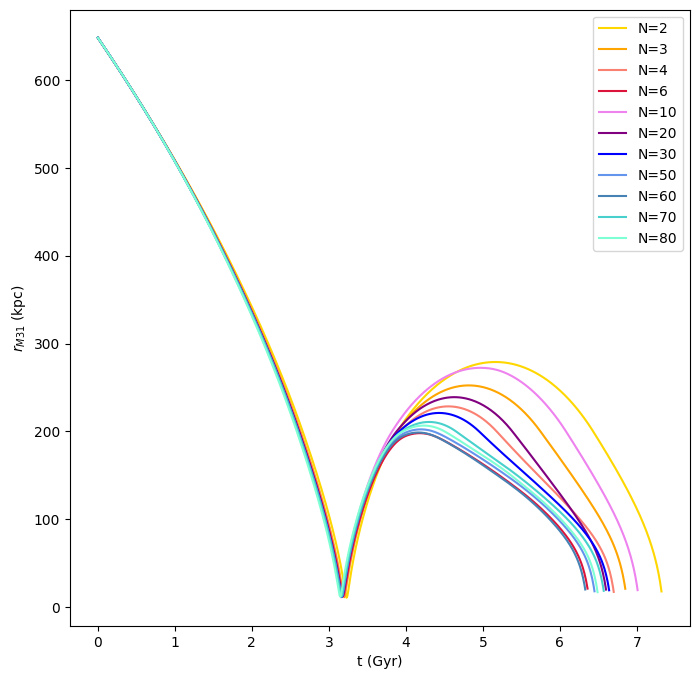

In [50]:
fig=plt.figure(figsize=(8,8), dpi=100)
plt.plot(t_all_2[times_M31_2],r_M31_2[times_M31_2],color='gold', label= 'N=2')
plt.plot(t_all_3[times_M31_3],r_M31_3[times_M31_3],color='orange', label= 'N=3')
plt.plot(t_all_4[times_M31_4],r_M31_4[times_M31_4],color='salmon', label= 'N=4')
plt.plot(t_all_6[times_M31_6],r_M31_6[times_M31_6],color='crimson', label= 'N=6')
plt.plot(t_all_10[times_M31_10],r_M31_10[times_M31_10],color='violet', label= 'N=10')
plt.plot(t_all_20[times_M31_20],r_M31_20[times_M31_20],color='purple', label= 'N=20')
plt.plot(t_all_30[times_M31_30],r_M31_30[times_M31_30],color='blue', label= 'N=30')
plt.plot(t_all_50[times_M31_50],r_M31_50[times_M31_50],color='cornflowerblue', label= 'N=50')
plt.plot(t_all_60[times_M31_60],r_M31_60[times_M31_60],color='steelblue', label= 'N=60')
plt.plot(t_all_50[times_M31_70],r_M31_70[times_M31_70],color='mediumturquoise', label= 'N=70')
plt.plot(t_all_50[times_M31_80],r_M31_80[times_M31_80],color='aquamarine', label= 'N=80')

plt.xlabel('t (Gyr)')
plt.ylabel('$r_{M31}$ (kpc)')
plt.legend()

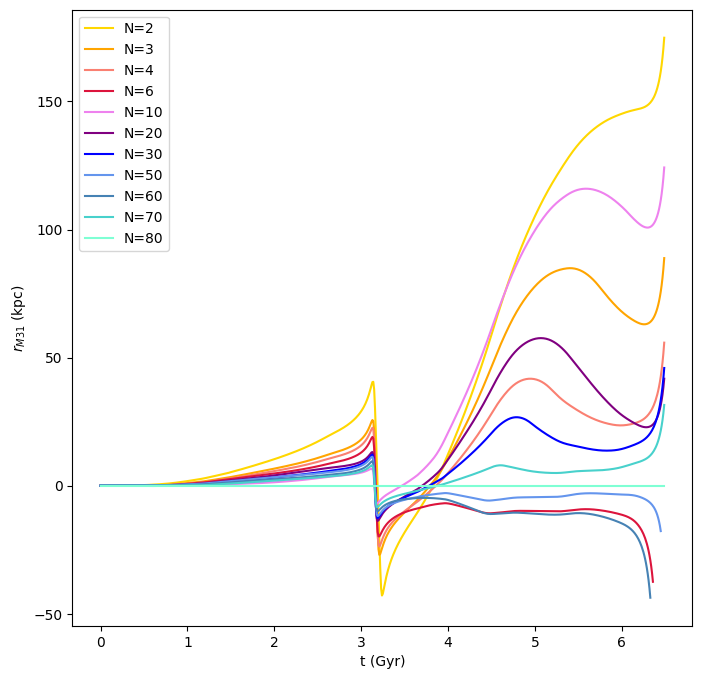

In [51]:



fig=plt.figure(figsize=(8,8), dpi=100)

indexes = list(set(times_M31_2) & set(times_M31_80))
plt.plot(t_all_2[indexes],r_M31_2[indexes] - r_M31_80[indexes],color='gold', label= 'N=2')

indexes = list(set(times_M31_3) & set(times_M31_80))
plt.plot(t_all_3[indexes],r_M31_3[indexes]- r_M31_80[indexes],color='orange', label= 'N=3')

indexes = list(set(times_M31_4) & set(times_M31_80))
plt.plot(t_all_4[indexes],r_M31_4[indexes]- r_M31_80[indexes],color='salmon', label= 'N=4')

indexes = list(set(times_M31_6) & set(times_M31_80))
plt.plot(t_all_6[indexes],r_M31_6[indexes]- r_M31_80[indexes],color='crimson', label= 'N=6')

indexes = list(set(times_M31_10) & set(times_M31_80))
plt.plot(t_all_10[indexes],r_M31_10[indexes]- r_M31_80[indexes],color='violet', label= 'N=10')

indexes = list(set(times_M31_20) & set(times_M31_80))
plt.plot(t_all_20[indexes],r_M31_20[indexes]- r_M31_80[indexes],color='purple', label= 'N=20')

indexes = list(set(times_M31_30) & set(times_M31_80))
plt.plot(t_all_30[indexes],r_M31_30[indexes]- r_M31_80[indexes],color='blue', label= 'N=30')

indexes = list(set(times_M31_50) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_50[indexes]- r_M31_80[indexes],color='cornflowerblue', label= 'N=50')

indexes = list(set(times_M31_60) & set(times_M31_80))
plt.plot(t_all_60[indexes],r_M31_60[indexes]- r_M31_80[indexes],color='steelblue', label= 'N=60')

indexes = list(set(times_M31_70) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_70[indexes]- r_M31_80[indexes],color='mediumturquoise', label= 'N=70')

indexes = list(set(times_M31_80) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_80[indexes]- r_M31_80[indexes],color='aquamarine', label= 'N=80')


plt.xlabel('t (Gyr)')
plt.ylabel('$r_{M31}$ (kpc)')
plt.legend()


Text(0.5, 0, 'Number of Galaxies')

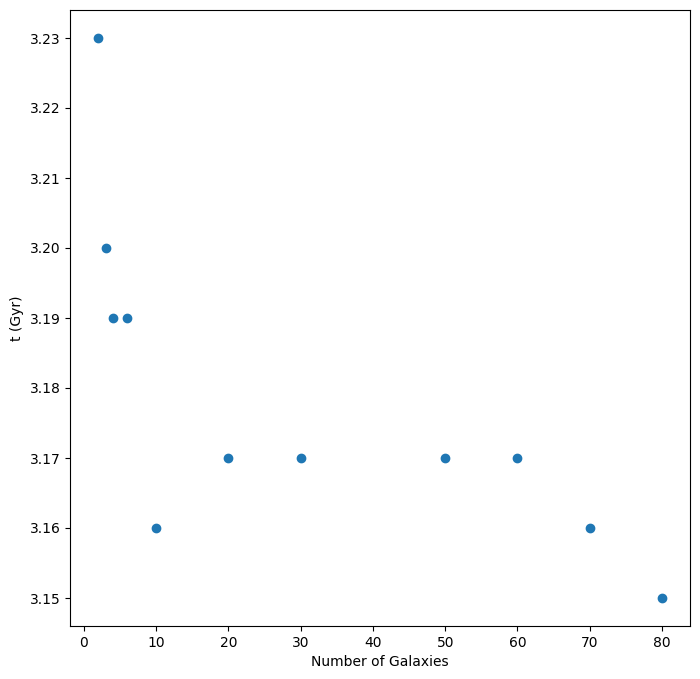

In [53]:
time_list=[t_2,t_3,t_4,t_6,t_10,t_20,t_30,t_50,t_60, t_70, t_80]
N_list=[2,3,4,6,10,20,30,50,60,70,80]
b_list=[b_2,b_3,b_4,b_6,b_10,b_20,b_30,b_50,b_60, b_70, b_80]
sum_mass_list=[sum_mass_2, sum_mass_3, sum_mass_4, sum_mass_6, sum_mass_10,sum_mass_20, sum_mass_30, sum_mass_50, sum_mass_60, sum_mass_70, sum_mass_80]

fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(N_list, time_list)
plt.ylabel('t (Gyr)')
plt.xlabel('Number of Galaxies')

Text(0, 0.5, 'Number of Galaxies')

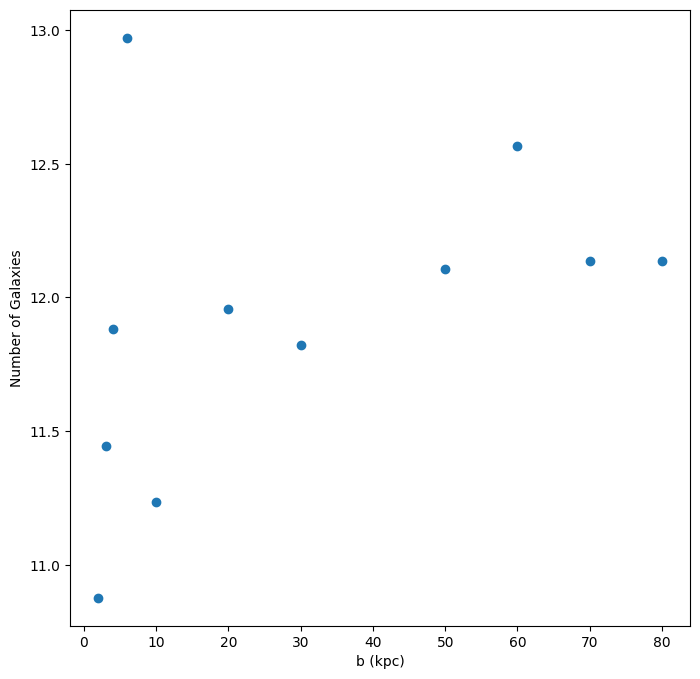

In [54]:
fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(N_list,b_list)
plt.xlabel('b (kpc)')
plt.ylabel('Number of Galaxies')

Text(0.5, 0, 'Number of Galaxies')

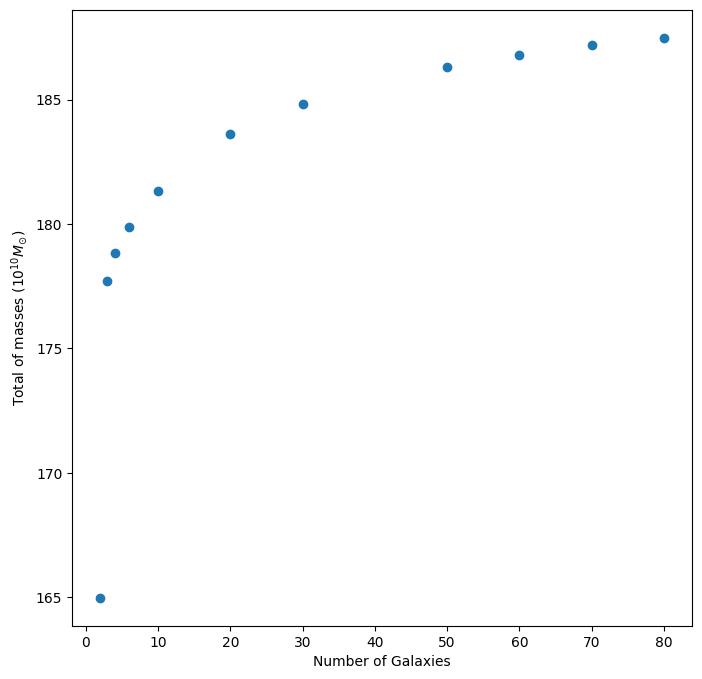

In [55]:
fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(N_list,sum_mass_list)
plt.ylabel('Total of masses ($10^{10} M_{\odot}$)')
plt.xlabel('Number of Galaxies')

Text(0.5, 0, 'b (kpc)')

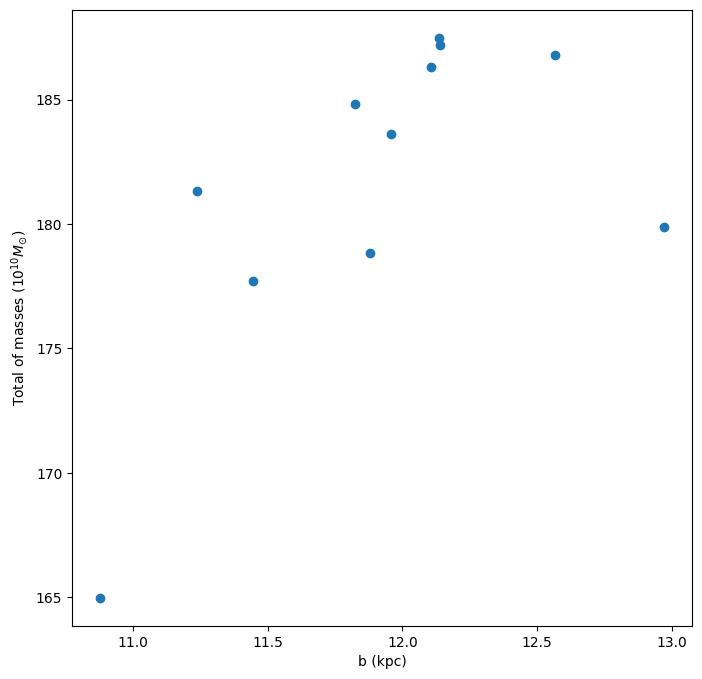

In [56]:
fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(b_list,sum_mass_list)
plt.ylabel('Total of masses ($10^{10} M_{\odot}$)')
plt.xlabel('b (kpc)')

In [57]:
N=2 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_2, r_M31_2, b_2, t_2, keep_mass_max, times_MW_2, times_M31_2, sum_mass_2 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=3 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_3, r_M31_3, b_3, t_3, keep_mass_max, times_MW_3, times_M31_3, sum_mass_3 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=4 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_4, r_M31_4, b_4, t_4, keep_mass_max, times_MW_4, times_M31_4, sum_mass_4 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=6 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_6, r_M31_6, b_6, t_6, keep_mass_max , times_MW_6, times_M31_6, sum_mass_6 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=10 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_10, r_M31_10,b_10,t_10, keep_mass_max , times_MW_10, times_M31_10, sum_mass_10 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=20 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_20, r_M31_20, b_20, t_20, keep_mass_max, times_MW_20, times_M31_20, sum_mass_20 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=30 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_30, r_M31_30, b_30, t_30, keep_mass_max , times_MW_30, times_M31_30, sum_mass_30= execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=50 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_50, r_M31_50, b_50, t_50, keep_mass_max, times_MW_50, times_M31_50, sum_mass_50 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=60 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_60, r_M31_60, b_60, t_60, keep_mass_max, times_MW_60, times_M31_60, sum_mass_60 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=70 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_70, r_M31_70, b_70, t_70, keep_mass_max, times_MW_70, times_M31_70, sum_mass_70 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

N=80 #Number of galaxies wished in the integration
positions, velocities, masses, pos_save, vel_save, mass_save,  t_all_80, r_M31_80, b_80, t_80, keep_mass_max, times_MW_80, times_M31_80, sum_mass_80 = execution(np.load('/mnt/c/Users/jehan/notebookjupy/Helsinki/testfile_2.npz')) #file 

['vmaxMW', 'vmaxM31', 'vmax', 'massMW', 'massM31', 'mass', 'velMW', 'velM31', 'vel', 'coordsMW', 'coordsM31', 'coords']
Number of galaxies in the simulation : 19743
Number of galaxies kept in the local group :  675
Number of galaxies kept after mass selection :  2
M31 is the most massive halo [[ True]]
MW is the second most massive halo [[ True]]
Nt: 1200
Galaxy 1 has merged with galaxy 0 at 5.639999999999924 Gyr
b MW - M31: 89.42932133402205
t = 4.83
Total velocity= 142.80823304891712 km/s
Radial velocity= -134.56289593964954 km/s
Transverse velocity= 47.82278183971391 km/s
['vmaxMW', 'vmaxM31', 'vmax', 'massMW', 'massM31', 'mass', 'velMW', 'velM31', 'vel', 'coordsMW', 'coordsM31', 'coords']
Number of galaxies in the simulation : 19743
Number of galaxies kept in the local group :  675
Number of galaxies kept after mass selection :  3
M31 is the most massive halo [[ True]]
MW is the second most massive halo [[ True]]
Nt: 1200
Galaxy 2 has merged with galaxy 0 at 1.7600000000000013 Gyr


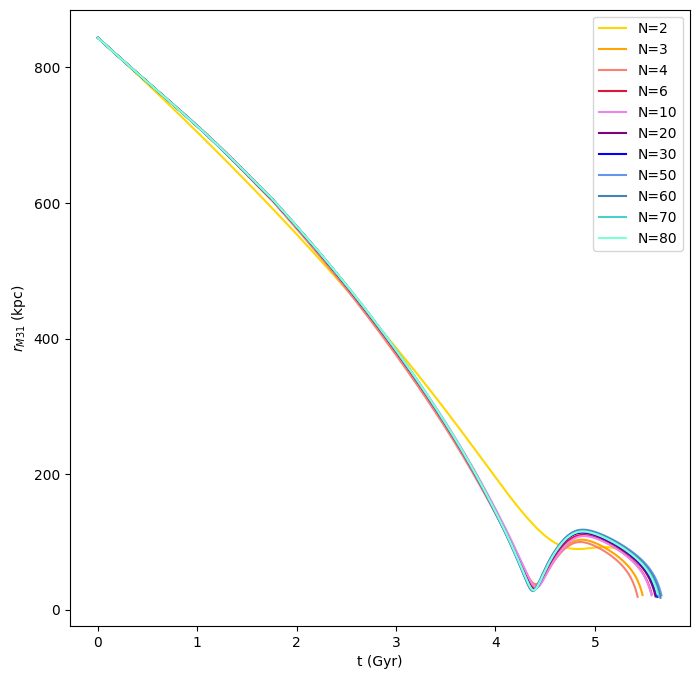

In [58]:
fig=plt.figure(figsize=(8,8), dpi=100)
plt.plot(t_all_2[times_M31_2],r_M31_2[times_M31_2],color='gold', label= 'N=2')
plt.plot(t_all_3[times_M31_3],r_M31_3[times_M31_3],color='orange', label= 'N=3')
plt.plot(t_all_4[times_M31_4],r_M31_4[times_M31_4],color='salmon', label= 'N=4')
plt.plot(t_all_6[times_M31_6],r_M31_6[times_M31_6],color='crimson', label= 'N=6')
plt.plot(t_all_10[times_M31_10],r_M31_10[times_M31_10],color='violet', label= 'N=10')
plt.plot(t_all_20[times_M31_20],r_M31_20[times_M31_20],color='purple', label= 'N=20')
plt.plot(t_all_30[times_M31_30],r_M31_30[times_M31_30],color='blue', label= 'N=30')
plt.plot(t_all_50[times_M31_50],r_M31_50[times_M31_50],color='cornflowerblue', label= 'N=50')
plt.plot(t_all_60[times_M31_60],r_M31_60[times_M31_60],color='steelblue', label= 'N=60')
plt.plot(t_all_50[times_M31_70],r_M31_70[times_M31_70],color='mediumturquoise', label= 'N=70')
plt.plot(t_all_50[times_M31_80],r_M31_80[times_M31_80],color='aquamarine', label= 'N=80')

plt.xlabel('t (Gyr)')
plt.ylabel('$r_{M31}$ (kpc)')
plt.legend()

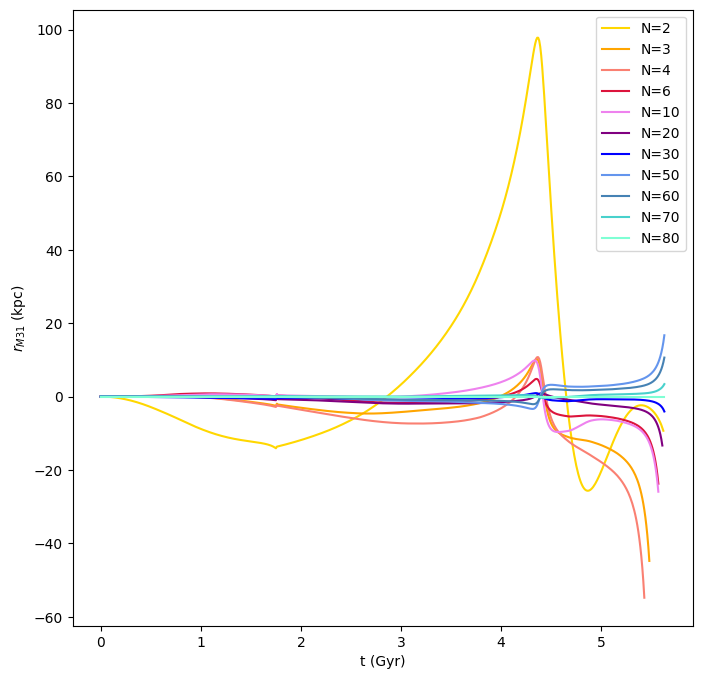

In [59]:

fig=plt.figure(figsize=(8,8), dpi=100)

indexes = list(set(times_M31_2) & set(times_M31_80))
plt.plot(t_all_2[indexes],r_M31_2[indexes] - r_M31_80[indexes],color='gold', label= 'N=2')

indexes = list(set(times_M31_3) & set(times_M31_80))
plt.plot(t_all_3[indexes],r_M31_3[indexes]- r_M31_80[indexes],color='orange', label= 'N=3')

indexes = list(set(times_M31_4) & set(times_M31_80))
plt.plot(t_all_4[indexes],r_M31_4[indexes]- r_M31_80[indexes],color='salmon', label= 'N=4')

indexes = list(set(times_M31_6) & set(times_M31_80))
plt.plot(t_all_6[indexes],r_M31_6[indexes]- r_M31_80[indexes],color='crimson', label= 'N=6')

indexes = list(set(times_M31_10) & set(times_M31_80))
plt.plot(t_all_10[indexes],r_M31_10[indexes]- r_M31_80[indexes],color='violet', label= 'N=10')

indexes = list(set(times_M31_20) & set(times_M31_80))
plt.plot(t_all_20[indexes],r_M31_20[indexes]- r_M31_80[indexes],color='purple', label= 'N=20')

indexes = list(set(times_M31_30) & set(times_M31_80))
plt.plot(t_all_30[indexes],r_M31_30[indexes]- r_M31_80[indexes],color='blue', label= 'N=30')

indexes = list(set(times_M31_50) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_50[indexes]- r_M31_80[indexes],color='cornflowerblue', label= 'N=50')

indexes = list(set(times_M31_60) & set(times_M31_80))
plt.plot(t_all_60[indexes],r_M31_60[indexes]- r_M31_80[indexes],color='steelblue', label= 'N=60')

indexes = list(set(times_M31_70) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_70[indexes]- r_M31_80[indexes],color='mediumturquoise', label= 'N=70')

indexes = list(set(times_M31_80) & set(times_M31_80))
plt.plot(t_all_50[indexes],r_M31_80[indexes]- r_M31_80[indexes],color='aquamarine', label= 'N=80')


plt.xlabel('t (Gyr)')
plt.ylabel('$r_{M31}$ (kpc)')
plt.legend()


Text(0.5, 0, 'Number of Galaxies')

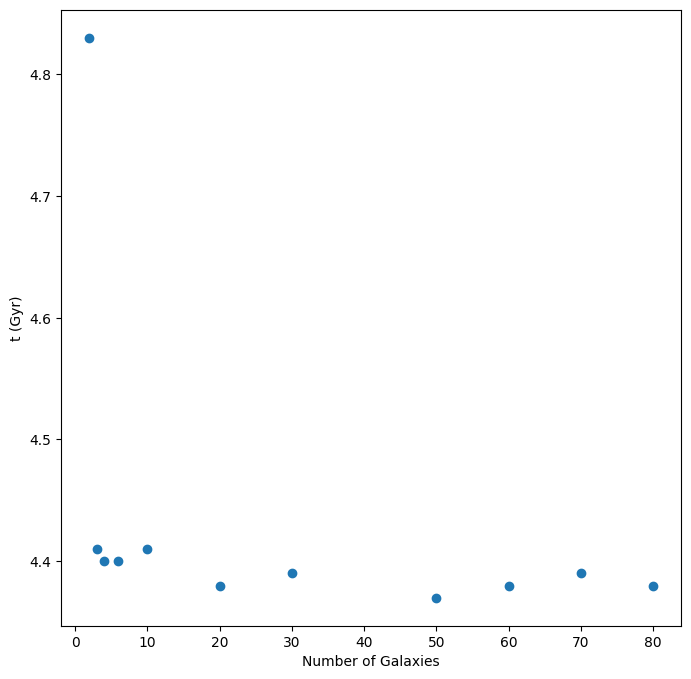

In [60]:
time_list=[t_2,t_3,t_4,t_6,t_10,t_20,t_30,t_50,t_60, t_70, t_80]
N_list=[2,3,4,6,10,20,30,50,60,70,80]
b_list=[b_2,b_3,b_4,b_6,b_10,b_20,b_30,b_50,b_60, b_70, b_80]
sum_mass_list=[sum_mass_2, sum_mass_3, sum_mass_4, sum_mass_6, sum_mass_10,sum_mass_20, sum_mass_30, sum_mass_50, sum_mass_60, sum_mass_70, sum_mass_80]

fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(N_list, time_list)
plt.ylabel('t (Gyr)')
plt.xlabel('Number of Galaxies')


Text(0.5, 0, 'Number of Galaxies')

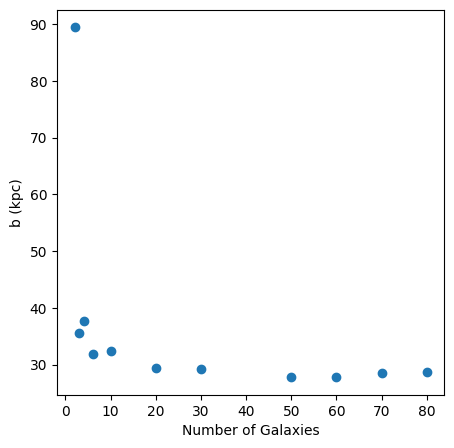

In [61]:
fig= plt.figure(figsize=(5,5), dpi=100)
plt.scatter(N_list, b_list)
plt.ylabel('b (kpc)')
plt.xlabel('Number of Galaxies')

Text(0.5, 0, 'Number of Galaxies')

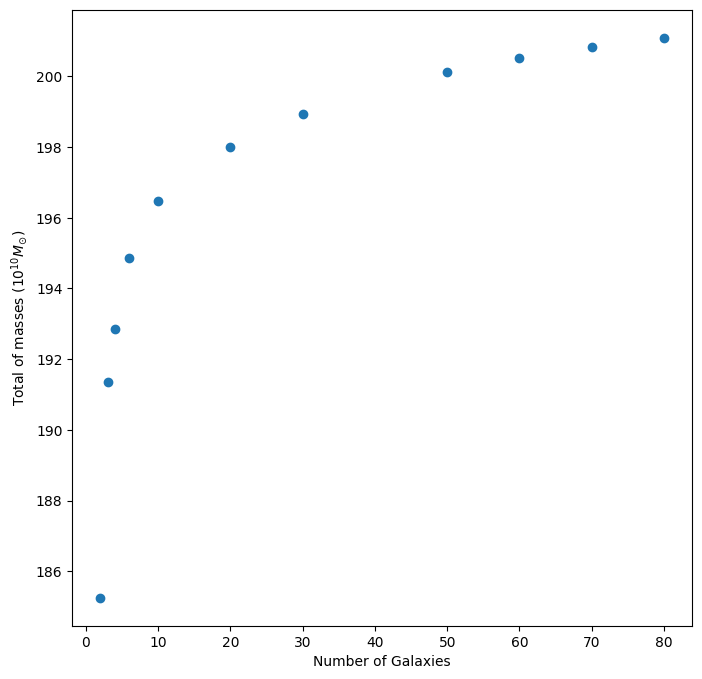

In [62]:
fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(N_list,sum_mass_list)
plt.ylabel('Total of masses ($10^{10} M_{\odot}$)')
plt.xlabel('Number of Galaxies')

Text(0.5, 0, 'b (kpc)')

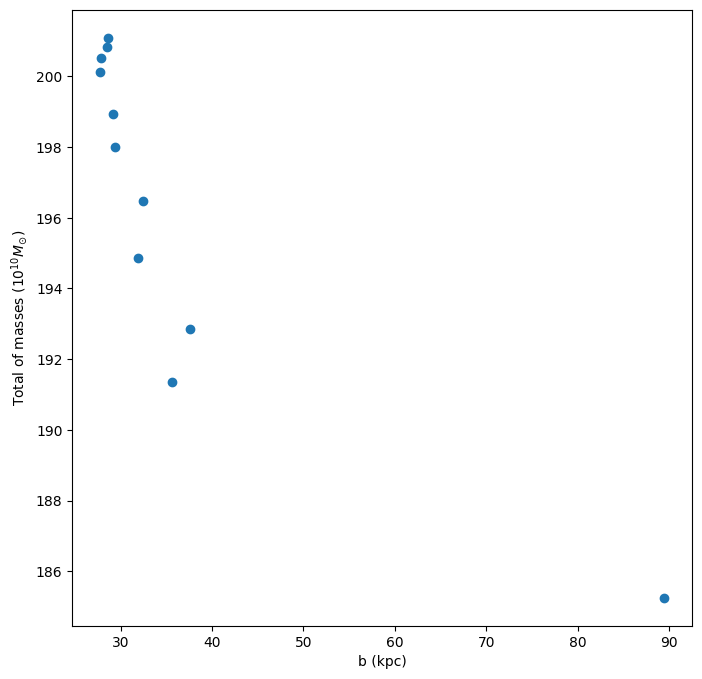

In [63]:
fig= plt.figure(figsize=(8,8), dpi=100)
plt.scatter(b_list,sum_mass_list)
plt.ylabel('Total of masses ($10^{10} M_{\odot}$)')
plt.xlabel('b (kpc)')

In [ ]:
#OrbitPlot(positions, masses, pos_save, mass_save, keep_mass_max, N)
